Description of Program

task: Explore making KDE and Heatmaps

project: IN-CORE Galveston Testbed

author: Nathanael Rosenheim

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns # for kernel density plots

C:\Users\nathanael99\AppData\Local\Temp\ipykernel_27980\1278713710.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz
import pyincore_viz as viz

In [3]:
# Check working directory - good practice for relative path access
os.getcwd()

'g:\\Shared drives\\HRRC_IN-CORE\\Text\\Beck 2024 Equity retrofit\\WorkNPR'

In [4]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_services = FragilityService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.16.0


In [5]:
# Housing Unit Allocation
housing_unit_allocation_id = "65173e4a6b7ce0714cdcd78f"
# load housing unit allocation as pandas dataframe
housing_unit_allocation = Dataset.from_data_service(housing_unit_allocation_id, data_service)
filename = housing_unit_allocation.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Allocation on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Housing Unit Allocation on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\65173e4a6b7ce0714cdcd78f\hua_v2-0-0_Galveston_TX_2010_rs1000_63ff6b135c35c0353d5ed3ac\hua_v2-0-0_Galveston_TX_2010_rs1000_63ff6b135c35c0353d5ed3ac.csv


In [6]:
hua_df = pd.read_csv(filename, header="infer")
hua_df.head()

,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,family,...,incomegroup,hhinc,randincome,poverty,BLOCKID10_str,guid,placeNAME10,huestimate,x,y
0,B481677201001000H001,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,...,6,3,31459.0,0.0,B481677201001000,missing building id,Friendswood,NaN,-95.211072,29.554253
1,B481677201001000H002,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,...,6,3,34695.0,0.0,B481677201001000,missing building id,Friendswood,NaN,-95.211072,29.554253
2,B481677201001000H003,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,...,7,3,38776.0,0.0,B481677201001000,missing building id,Friendswood,NaN,-95.211072,29.554253
3,B481677201001000H004,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,...,10,3,52398.0,0.0,B481677201001000,missing building id,Friendswood,NaN,-95.211072,29.554253
4,B481677201001000H005,481677201001000,481677201001,48167720100,48167,1,1.0,1.0,0.0,0.0,...,11,3,69564.0,0.0,B481677201001000,missing building id,Friendswood,NaN,-95.211072,29.554253


## Clean Data
Select data for Galveston Island. Which is the city of Galveston and Jamaica Beach.

<Axes: >

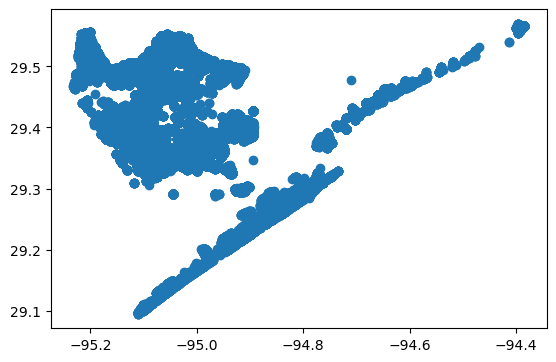

In [7]:
# convert dataframe to geodataframe
hua_gdf = gpd.GeoDataFrame(hua_df, geometry=gpd.points_from_xy(hua_df.x, hua_df.y))
hua_gdf.crs = "EPSG:4326"
# plot data
hua_gdf.plot()

In [8]:
# list all unique values of placeNAME10 with sum of people
hua_gdf[['numprec','placeNAME10']].groupby('placeNAME10').sum()

,numprec
placeNAME10,
Bacliff,8521
Bayou Vista,1537
Bolivar Peninsula,2405
Clear Lake Shores,1063
Dickinson,18533
Friendswood,25436
Galveston,47453
Hitchcock,6910
Jamaica Beach,983


In [9]:
# select if placeNAME10 Galveston or Jamaica Beach
hua_gdf_island = hua_gdf[hua_df['placeNAME10'].isin(['Galveston','Jamaica Beach'])].copy(deep=True)

In [10]:
hua_gdf_island[['numprec','placeNAME10']].groupby('placeNAME10').sum()

,numprec
placeNAME10,
Galveston,47453
Jamaica Beach,983


<Axes: >

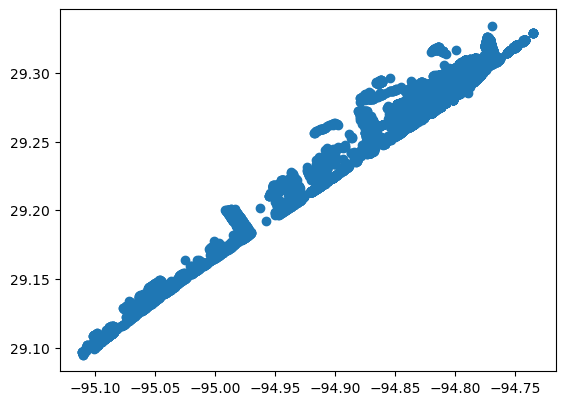

In [11]:
# plot data
hua_gdf_island.plot()

### Split Income into quartiles

In [12]:
# Assign quartiles to 'quartile' column
hua_gdf_island['quartile'] = pd.qcut(hua_gdf_island['randincome'], q=4, labels=False)

# Create a lower quartile column 
hua_gdf_island['lower_quart'] = hua_gdf_island['quartile'] == 0

# Create a uppter quartile column 
hua_gdf_island['upper_quart'] = hua_gdf_island['quartile'] == 3

In [13]:
# describe randomincome by quartile
hua_gdf_island.groupby('quartile')['randincome'].describe()

,count,mean,std,min,25%,50%,75%,max
quartile,,,,,,,,
0.0,5110.0,9009.111155,5243.636115,2.0,4386.00,9107.5,13425.00,18447.0
1.0,5108.0,28163.534260,5723.073118,18448.0,23293.50,27869.5,32966.75,38845.0
2.0,5108.0,54616.583399,10187.443877,38856.0,46016.75,53499.0,63035.75,74651.0
3.0,5109.0,131275.571736,52006.686910,74659.0,89859.00,111708.0,164611.00,249911.0


In [14]:
# describe income by lower quartile
hua_gdf_island.groupby('lower_quart')['randincome'].describe()

,count,mean,std,min,25%,50%,75%,max
lower_quart,,,,,,,,
False,15325.0,71355.806656,53472.926054,18448.0,32969.0,53501.0,89859.0,249911.0
True,5110.0,9009.111155,5243.636115,2.0,4386.0,9107.5,13425.0,18447.0


In [15]:
# describe income by high quartile
hua_gdf_island.groupby('upper_quart')['randincome'].describe()

,count,mean,std,min,25%,50%,75%,max
upper_quart,,,,,,,,
False,15326.0,30593.592523,20108.160191,2.0,13425.0,27867.5,46009.5,74651.0
True,5109.0,131275.571736,52006.686910,74659.0,89859.0,111708.0,164611.0,249911.0


In [16]:
# select observations where low quartile = 1
hua_gdf_island_lowquart = hua_gdf_island[hua_gdf_island['lower_quart'] == 1].copy(deep=True)
# reset index for heatmap
hua_gdf_island_lowquart.reset_index(inplace=True)
hua_gdf_island_lowquart[['numprec','placeNAME10']].groupby('placeNAME10').sum()

,numprec
placeNAME10,
Galveston,10153
Jamaica Beach,94


In [17]:
# select observations high quartile = 1
hua_gdf_islan_upperquart = hua_gdf_island[hua_gdf_island['upper_quart'] == 1].copy(deep=True)
# reset index for heatmap
hua_gdf_islan_upperquart.reset_index(inplace=True)
hua_gdf_islan_upperquart[['numprec','placeNAME10']].groupby('placeNAME10').sum()

,numprec
placeNAME10,
Galveston,11843
Jamaica Beach,484


In [18]:
# select observations where poverty = 1
hua_gdf_island_poverty = hua_gdf_island[hua_gdf_island['poverty'] == 1].copy(deep=True)
# reset index for heatmap
hua_gdf_island_poverty.reset_index(inplace=True)
hua_gdf_island_poverty[['numprec','placeNAME10']].groupby('placeNAME10').sum()

,numprec
placeNAME10,
Galveston,11023
Jamaica Beach,81


<Axes: >

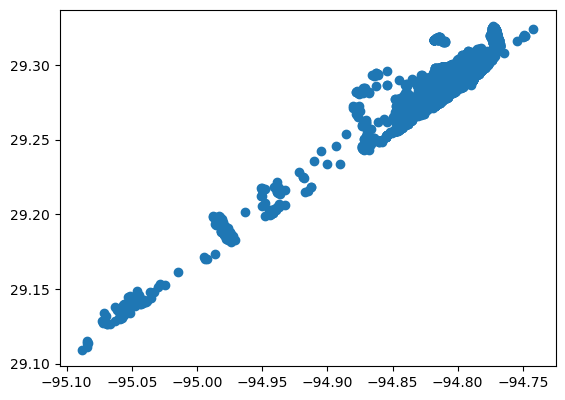

In [19]:
hua_gdf_island_lowquart.plot()

<Axes: >

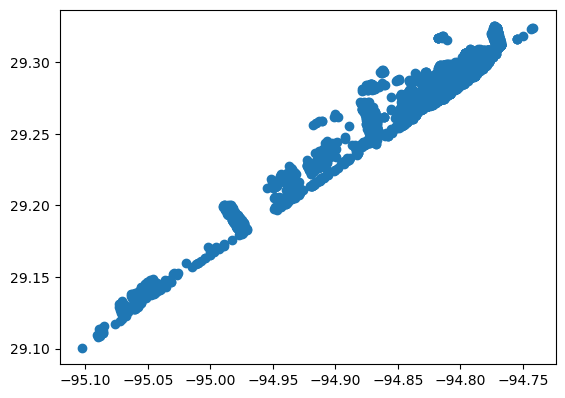

In [20]:
# plot data
hua_gdf_islan_upperquart.plot()


### KDE Plot by income

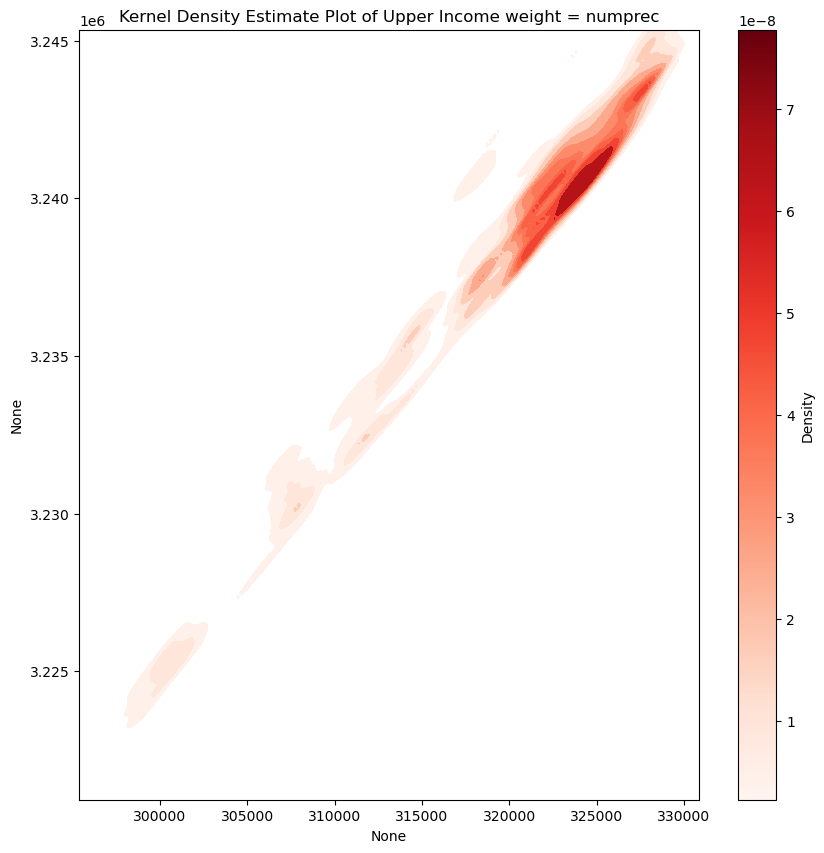

In [21]:
# Thank you ChatGPT-4
# https://chat.openai.com/g/g-cZDUaJHDk-pyncoda/c/1209d5b3-dbdf-4234-80d4-2ce2e4955bc9

# Using UTM zone 15N for Texas
# The KDE value will represent the probability density per square meter.
gdf = hua_gdf_islan_upperquart.to_crs(epsg=32615)

# Extract the points' x and y coordinates for KDE
x = gdf.geometry.x
y = gdf.geometry.y
weights = gdf['numprec']

# Set up the figure and axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


# Plot KDE using seaborn's kdeplot function
# Capture the return value, which is a QuadContourSet object in this case
contour = sns.kdeplot(x=gdf.geometry.x, 
                      y= gdf.geometry.y, 
                      weights=gdf['numprec'],
                      ax=ax, bw_adjust=0.5, 
                      fill=True, 
                      cmap="Reds")

# Optionally, set the x and y limits to the bounds of your GeoDataFrame for better focus
ax.set_xlim(gdf.total_bounds[[0, 2]])
ax.set_ylim(gdf.total_bounds[[1, 3]])

# Add a colorbar to the plot
norm = plt.Normalize(vmin=contour.collections[0].get_clim()[0], 
                     vmax=contour.collections[-1].get_clim()[1])
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Density')

# Optionally, add a title to your plot
ax.set_title('Kernel Density Estimate Plot of Upper Income weight = numprec')

# Show the plot
plt.show()

# Save the figure to a file
fig.savefig('KDE_plot_southeast_texas_upperincome.png', dpi=300)

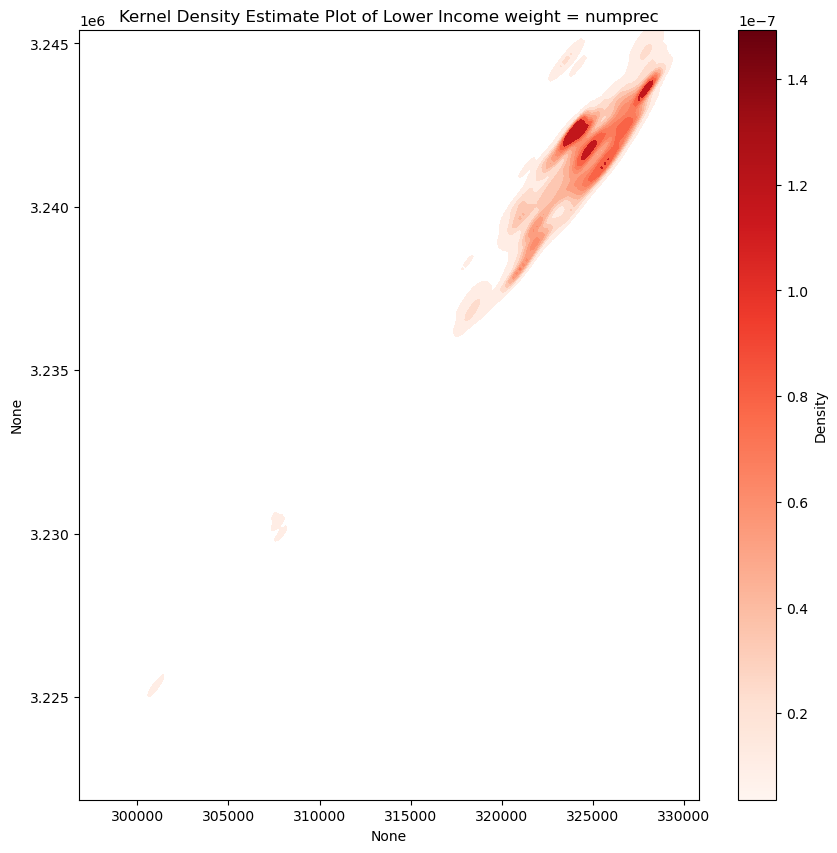

In [22]:
# Thank you ChatGPT-4
# https://chat.openai.com/g/g-cZDUaJHDk-pyncoda/c/1209d5b3-dbdf-4234-80d4-2ce2e4955bc9

# Using UTM zone 15N for Texas
# The KDE value will represent the probability density per square meter.
gdf = hua_gdf_island_lowquart.to_crs(epsg=32615)

# Extract the points' x and y coordinates for KDE
x = gdf.geometry.x
y = gdf.geometry.y
weights = gdf['numprec']

# Set up the figure and axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


# Plot KDE using seaborn's kdeplot function
# Capture the return value, which is a QuadContourSet object in this case
contour = sns.kdeplot(x=gdf.geometry.x, 
                      y= gdf.geometry.y, 
                      weights=gdf['numprec'],
                      ax=ax, bw_adjust=0.5, 
                      fill=True, 
                      cmap="Reds")

# Optionally, set the x and y limits to the bounds of your GeoDataFrame for better focus
ax.set_xlim(gdf.total_bounds[[0, 2]])
ax.set_ylim(gdf.total_bounds[[1, 3]])

# Add a colorbar to the plot
norm = plt.Normalize(vmin=contour.collections[0].get_clim()[0], 
                     vmax=contour.collections[-1].get_clim()[1])
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Density')

# Optionally, add a title to your plot
ax.set_title('Kernel Density Estimate Plot of Lower Income weight = numprec')

# Show the plot
plt.show()

# Save the figure to a file
fig.savefig('KDE_plot_southeast_texas_lowincome.png', dpi=300)

In [23]:
# select observations where low income, tenure = 2, and race != 1 and hispan != 0
# low income is defined as below median income of randincome
median_income = hua_gdf_island['randincome'].median()
print("The median income is: "+str(median_income))

condition1 = (hua_gdf_island['randincome'] <= median_income)
condition2 = (hua_gdf_island['ownershp'] == 2)
condition3 = (hua_gdf_island['race'] != 1)
condition4 = (hua_gdf_island['hispan'] != 0)
hua_gdf_highSVI = hua_gdf_island[condition1 & condition2 & condition3 & condition4].copy(deep=True)
# reset index for heatmap
hua_gdf_highSVI.reset_index(inplace=True)
hua_gdf_highSVI[['numprec','placeNAME10']].groupby('placeNAME10').sum()

The median income is: 38845.0


,numprec
placeNAME10,
Galveston,2129
Jamaica Beach,8


<Axes: >

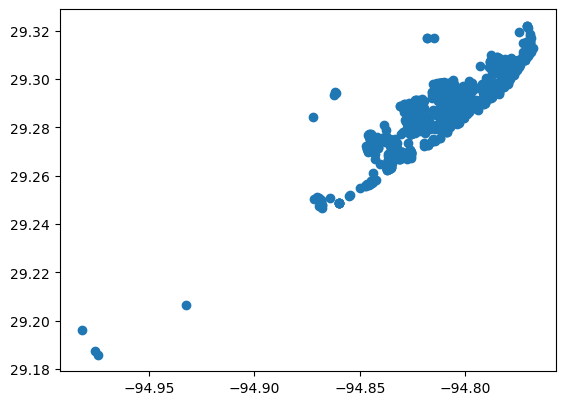

In [24]:
hua_gdf_highSVI.plot()

## Explore Data
Make a heat map of poverty

In [25]:
help(geoviz.plot_heatmap_from_gdf)

Help on function plot_heatmap_from_gdf in module pyincore_viz.geoutil:

plot_heatmap_from_gdf(gdf, fld_name, radius=10, blur=10, max=1, multiplier=1, name='')
    Creates ipyleaflet map object and fit the map using the bounding box information.
    
    Args:
        gdf (GeoDataFrame): GeoPandas geodataframe.
        fld_name (str): column name to be plot in heat map.
        radius (float): Radius of each "point" of the heatmap.
        blur (float): Amount of blur.
        max (float): Maximum point intensity.
        multiplier (float): A multiplication factor for making fld value to more clearly in the map.
        name (str): A name that represents the layer.
    
    Returns:
        obj: An ipyleaflet map.



In [26]:
map = geoviz.plot_heatmap_from_gdf(gdf = hua_gdf_island_poverty,
                            fld_name = 'numprec',
                            radius = 5,
                            blur = 5,
                            name = 'Poverty')
map

Map(center=[29.217564353279595, -94.9151435443301], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [27]:
map = geoviz.plot_heatmap_from_gdf(gdf = hua_gdf_highSVI,
                            fld_name = 'numprec',
                            radius = 10,
                            blur = 5,
                            name = 'Low income minorty renters')
map

Map(center=[29.2539943524561, -94.87476235868948], controls=(ZoomControl(options=['position', 'zoom_in_text', …

## Try to run a kernel density plot

https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/kernel-density.htm

Advice from Heather Smith on:
https://community.esri.com/t5/arcgis-pro-questions/more-indepth-explanation-of-radius-for-heat-map/td-p/28555

HeatherSmith
05-26-2020 11:10 AM
Hi,

For your use case, I would recommend using the Kernal Density geoprocessing tool instead. Heat Map symbology is good for quick and dynamic visualization. But for reliable and defensible density analysis, the tool will give you more control.


In [28]:
help(sns.kdeplot)

Help on function kdeplot in module seaborn.distributions:

kdeplot(data=None, *, x=None, y=None, hue=None, weights=None, palette=None, hue_order=None, hue_norm=None, color=None, fill=None, multiple='layer', common_norm=True, common_grid=False, cumulative=False, bw_method='scott', bw_adjust=1, warn_singular=True, log_scale=None, levels=10, thresh=0.05, gridsize=200, cut=3, clip=None, legend=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=None, **kwargs)
    Plot univariate or bivariate distributions using kernel density estimation.
    
    A kernel density estimate (KDE) plot is a method for visualizing the
    distribution of observations in a dataset, analogous to a histogram. KDE
    represents the data using a continuous probability density curve in one or
    more dimensions.
    
    The approach is explained further in the :ref:`user guide <tutorial_kde>`.
    
    Relative to a histogram, KDE can produce a plot that is less cluttered and
    more interpretable, especially whe

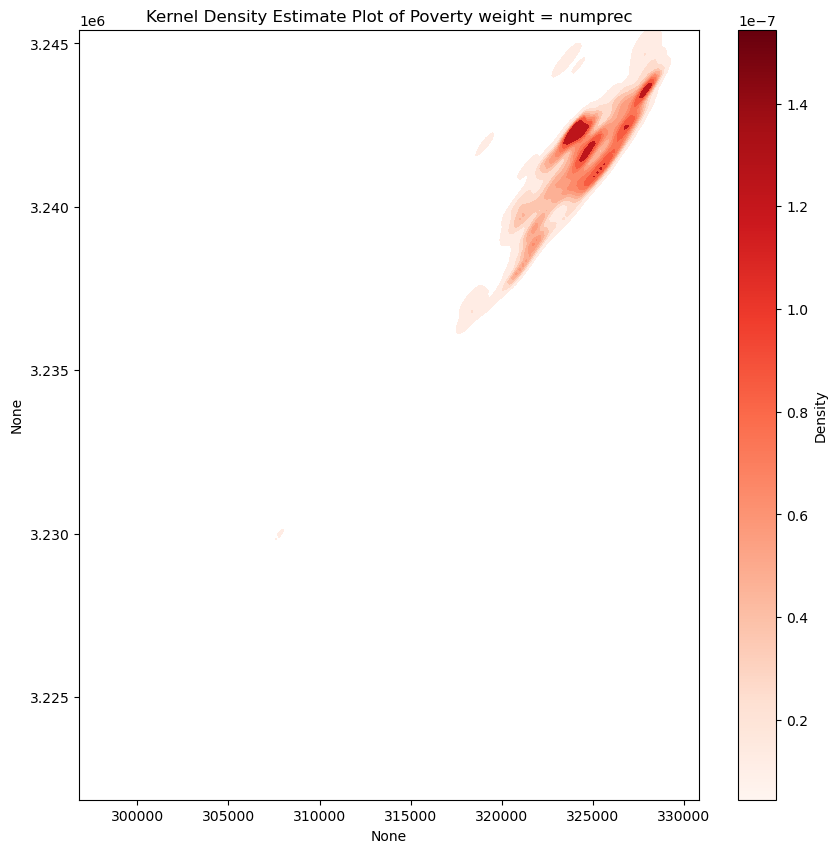

In [29]:
# Thank you ChatGPT-4
# https://chat.openai.com/g/g-cZDUaJHDk-pyncoda/c/1209d5b3-dbdf-4234-80d4-2ce2e4955bc9

# Using UTM zone 15N for Texas
# The KDE value will represent the probability density per square meter.
gdf = hua_gdf_island_poverty.to_crs(epsg=32615)

# Extract the points' x and y coordinates for KDE
x = gdf.geometry.x
y = gdf.geometry.y
weights = gdf['numprec']

# Set up the figure and axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


# Plot KDE using seaborn's kdeplot function
# Capture the return value, which is a QuadContourSet object in this case
contour = sns.kdeplot(x=gdf.geometry.x, 
                      y= gdf.geometry.y, 
                      weights=gdf['numprec'],
                      ax=ax, bw_adjust=0.5, 
                      fill=True, 
                      cmap="Reds")

# Optionally, set the x and y limits to the bounds of your GeoDataFrame for better focus
ax.set_xlim(gdf.total_bounds[[0, 2]])
ax.set_ylim(gdf.total_bounds[[1, 3]])

# Add a colorbar to the plot
norm = plt.Normalize(vmin=contour.collections[0].get_clim()[0], 
                     vmax=contour.collections[-1].get_clim()[1])
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Density')

# Optionally, add a title to your plot
ax.set_title('Kernel Density Estimate Plot of Poverty weight = numprec')

# Show the plot
plt.show()

# Save the figure to a file
fig.savefig('KDE_plot_southeast_texasv6.png', dpi=300)

## TO DO
I have tried to export the KDE as a raster with spatial information. However, it seems that once I save the geotiff the orientation rotates 90 degrees.

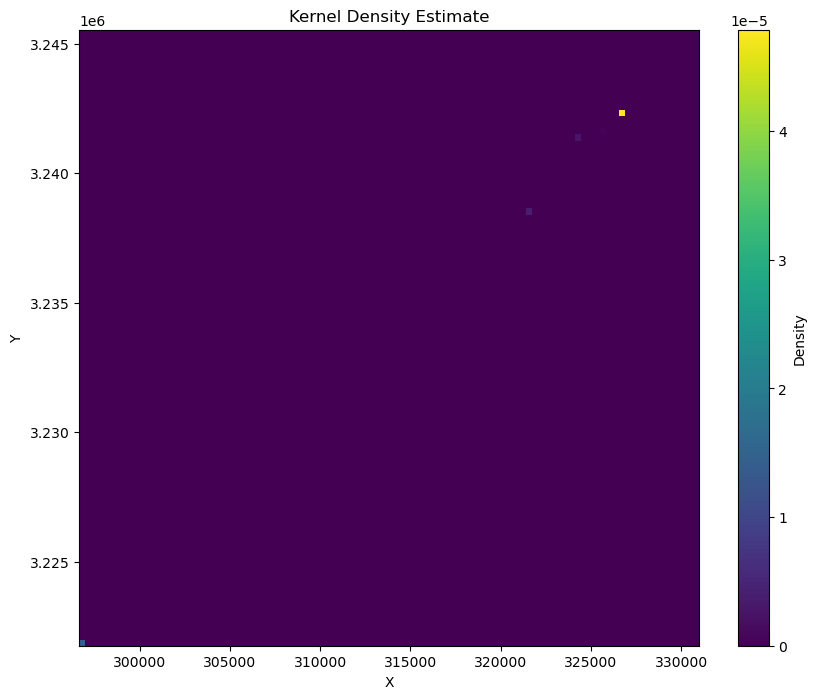

In [30]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Load your spatial dataset
gdf = hua_gdf_island_poverty.to_crs(epsg=32615)  # Example: UTM zone 15N for Texas

# Extract x and y coordinates
X = np.vstack([gdf.geometry.x, gdf.geometry.y]).T

# Optionally, specify weights based on a population field or other
weights = gdf['numprec'].values  # Replace 'population_field' with your column name

# Initialize KernelDensity object
kde = KernelDensity(bandwidth=1.0, kernel='gaussian', metric='euclidean',
                    algorithm='ball_tree', atol=0)

# Fit the model to your data (with weights if applicable)
kde.fit(X, sample_weight=weights)

# Create a grid to evaluate the model
x_min, y_min, x_max, y_max = gdf.total_bounds
x_grid = np.linspace(x_min, x_max, 100)
y_grid = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_grid, y_grid)
grid = np.vstack([xx.ravel(), yy.ravel()]).T

# Evaluate the density model on the grid
log_density = kde.score_samples(grid)
density = np.exp(log_density).reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 8))
plt.pcolormesh(xx, yy, density, shading='auto')
plt.colorbar(label='Density')
plt.title('Kernel Density Estimate')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

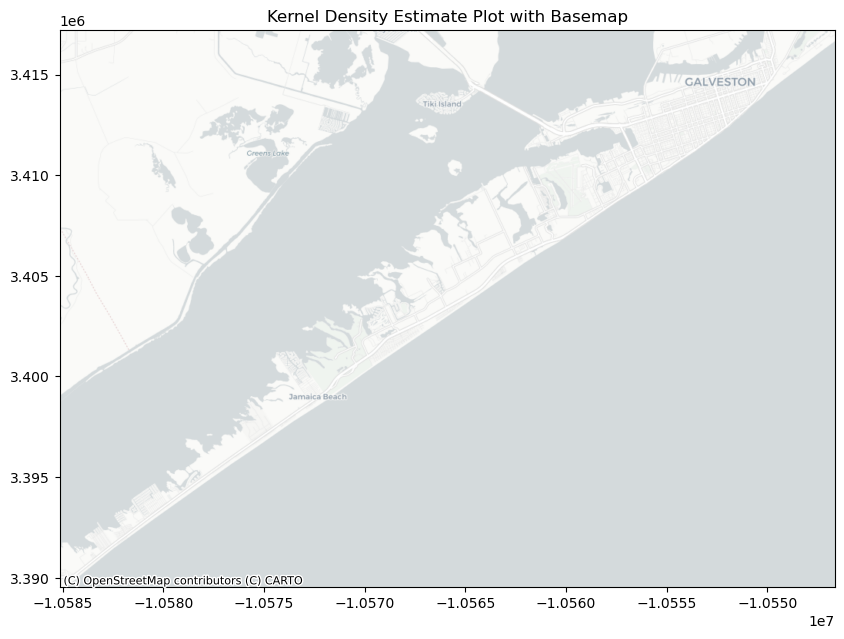

In [31]:
import numpy as np
from scipy.stats import gaussian_kde
import contextily as ctx

# Project your GeoDataFrame to a suitable CRS for web mapping (typically EPSG:3857)
gdf_projected = hua_gdf_island_poverty.to_crs(epsg=3857)

# Extract x and y coordinates
x = gdf_projected.geometry.x
y = gdf_projected.geometry.y

# Calculate the KDE
kde = gaussian_kde([x, y])
# Create a grid of points where the KDE will be evaluated
xmin, ymin, xmax, ymax = gdf_projected.total_bounds
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # Adjust grid size as needed
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kde(positions).T, xx.shape)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Use imshow to plot the KDE, making 0 values transparent with the 'alpha' parameter
kde_plot = ax.imshow(np.rot90(f), cmap="viridis", extent=[xmin, xmax, ymin, ymax], alpha=0.7)
# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_title('Kernel Density Estimate Plot with Basemap')
plt.show()

<Axes: >

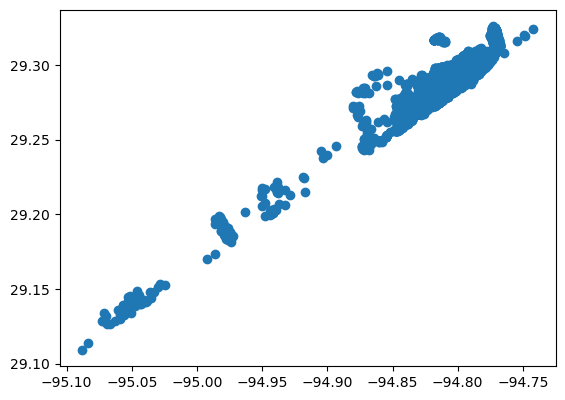

In [32]:
hua_gdf_island_poverty.plot()

<Axes: >

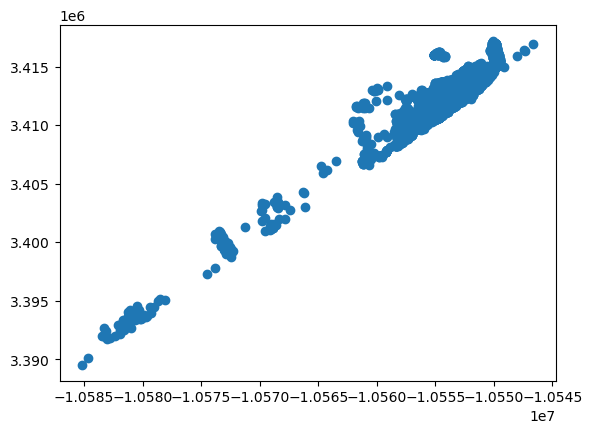

In [33]:
gdf = hua_gdf_island_poverty.to_crs(epsg=3857)
gdf.plot()

In [34]:
hua_gdf_island_poverty.head()

,index,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,BLOCKID10_str,guid,placeNAME10,huestimate,x,y,geometry,quartile,lower_quart,upper_quart
0,13995,B481677240001010H001,481677240001010,481677240001,48167724000,48167,1,2.0,1.0,0.0,...,B481677240001010,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,Galveston,71.0,-94.818265,29.316873,POINT (-94.81827 29.31687),0.0,True,False
1,13998,B481677240001010H004,481677240001010,481677240001,48167724000,48167,1,2.0,1.0,0.0,...,B481677240001010,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,Galveston,71.0,-94.818265,29.316873,POINT (-94.81827 29.31687),0.0,True,False
2,14002,B481677240001010H008,481677240001010,481677240001,48167724000,48167,1,2.0,1.0,0.0,...,B481677240001010,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,Galveston,71.0,-94.818265,29.316873,POINT (-94.81827 29.31687),0.0,True,False
3,14006,B481677240001040H001,481677240001040,481677240001,48167724000,48167,1,1.0,1.0,0.0,...,B481677240001040,missing building id,Galveston,NaN,-94.791965,29.309169,POINT (-94.79197 29.30917),0.0,True,False
4,14010,B481677240001047H009,481677240001047,481677240001,48167724000,48167,1,2.0,1.0,0.0,...,B481677240001047,dadbf567-9d8e-4796-82f9-348dfb259ef5,Galveston,8.0,-94.814869,29.316783,POINT (-94.81487 29.31678),0.0,True,False


In [35]:
# Assuming gdf is your GeoDataFrame and it's already projected to a suitable CRS
gdf = hua_gdf_island_poverty.to_crs(epsg=3857)

# Create an empty list to hold duplicated points
duplicated_rows = []

# Iterate over each row and duplicate based on numprec
for index, row in gdf.iterrows():
    n_duplicates = int(row['numprec'])  # Convert numprec to int, assuming it's integer-compatible
    for _ in range(n_duplicates):
        duplicated_rows.append(row)

# Convert the list of duplicated rows back to a GeoDataFrame
duplicated_gdf = gpd.GeoDataFrame(duplicated_rows, crs=gdf.crs)

In [36]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from scipy.stats import gaussian_kde

# Convert your GeoDataFrame to UTM Zone 15N
gdf_utm = duplicated_gdf.to_crs(epsg=32615)

# Load your GeoDataFrame and ensure it's projected (example uses WGS 84 / Pseudo-Mercator)
gdf = gdf_utm

# Extract x and y coordinates
x = gdf.geometry.x
y = gdf.geometry.y

# Calculate KDE
kde = gaussian_kde([x, y])

# Define your grid dimensions
xmin, ymin, xmax, ymax = gdf.total_bounds
x_divisions = 50  # Desired resolution
y_divisions = 50
# Calculate cell size in meters
cell_width = (xmax - xmin) / x_divisions
cell_height = (ymax - ymin) / y_divisions

print(f"Each grid cell is approximately {cell_width:.2f}m by {cell_height:.2f}m.")

# create two arrays points at resolution x_res by y_res
xx, yy = np.mgrid[xmin:xmax:x_divisions*1j, ymin:ymax:y_divisions*1j]
# convert the grid points to a 2D array
positions = np.vstack([xx.ravel(), yy.ravel()])
# 
density = np.reshape(kde(positions).T, xx.shape)

Each grid cell is approximately 680.45m by 471.00m.


In [37]:
help(gaussian_kde)

Help on class gaussian_kde in module scipy.stats._kde:

class gaussian_kde(builtins.object)
 |  gaussian_kde(dataset, bw_method=None, weights=None)
 |  
 |  Representation of a kernel-density estimate using Gaussian kernels.
 |  
 |  Kernel density estimation is a way to estimate the probability density
 |  function (PDF) of a random variable in a non-parametric way.
 |  `gaussian_kde` works for both uni-variate and multi-variate data.   It
 |  includes automatic bandwidth determination.  The estimation works best for
 |  a unimodal distribution; bimodal or multi-modal distributions tend to be
 |  oversmoothed.
 |  
 |  Parameters
 |  ----------
 |  dataset : array_like
 |      Datapoints to estimate from. In case of univariate data this is a 1-D
 |      array, otherwise a 2-D array with shape (# of dims, # of data).
 |  bw_method : str, scalar or callable, optional
 |      The method used to calculate the estimator bandwidth.  This can be
 |      'scott', 'silverman', a scalar constan

In [38]:
# Ensure density is a numpy array
density_array = np.array(density)

# Calculate statistics
count = density_array.size
mean = np.mean(density_array)
std = np.std(density_array)
minimum = np.min(density_array)
percentile25 = np.percentile(density_array, 25)
median = np.median(density_array)
percentile75 = np.percentile(density_array, 75)
maximum = np.max(density_array)

# Print summary statistics
print("Count:", count)
print("Mean:", mean)
print("Std:", std)
print("Min:", minimum)
print("25th percentile:", percentile25)
print("Median:", median)
print("75th percentile:", percentile75)
print("Max:", maximum)

Count: 2500
Mean: 1.1944194362370647e-09
Std: 7.2032715070863915e-09
Min: 0.0
25th percentile: 0.0
Median: 1.4501168341555744e-165
75th percentile: 1.0663443250787068e-24
Max: 8.528591067885623e-08


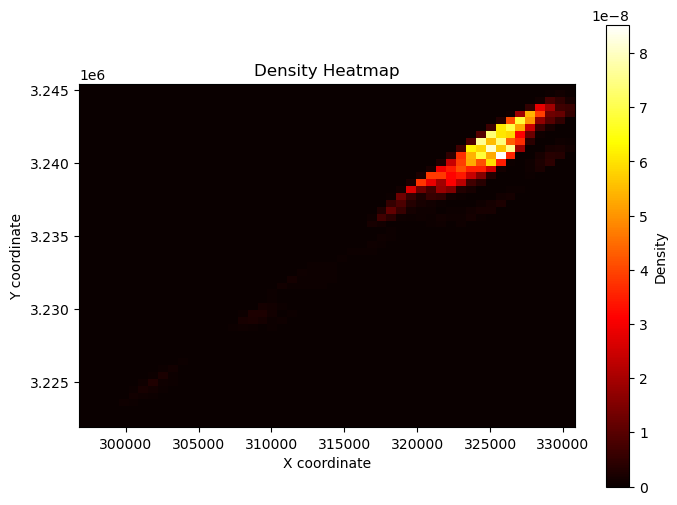

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# Display the density as a heatmap. Use the 'cmap' parameter to choose a color map.
plt.imshow(density, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='hot')
plt.colorbar(label='Density')
plt.title('Density Heatmap')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

In [40]:
# Ensure density is a numpy array
density_array = np.array(density)

# Calculate statistics
count = density_array.size
mean = np.mean(density_array)
std = np.std(density_array)
minimum = np.min(density_array)
percentile25 = np.percentile(density_array, 25)
median = np.median(density_array)
percentile75 = np.percentile(density_array, 75)
maximum = np.max(density_array)

# Print summary statistics
print("Count:", count)
print("Mean:", mean)
print("Std:", std)
print("Min:", minimum)
print("25th percentile:", percentile25)
print("Median:", median)
print("75th percentile:", percentile75)
print("Max:", maximum)

Count: 2500
Mean: 1.1944194362370647e-09
Std: 7.2032715070863915e-09
Min: 0.0
25th percentile: 0.0
Median: 1.4501168341555744e-165
75th percentile: 1.0663443250787068e-24
Max: 8.528591067885623e-08


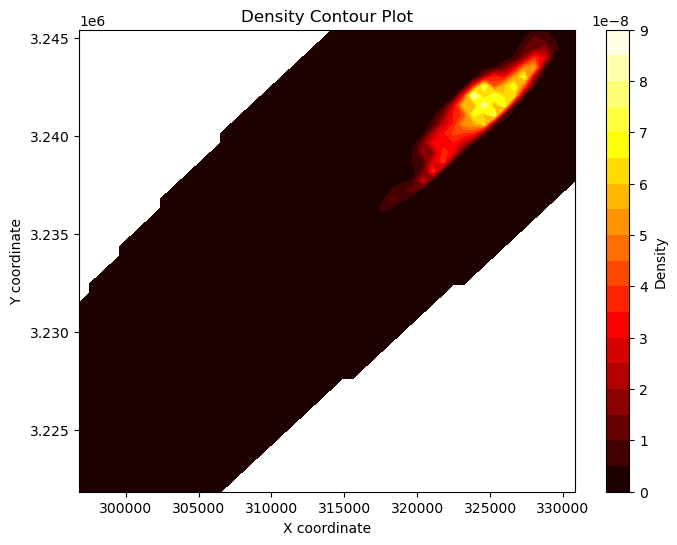

In [41]:
# Set density values that are 0 to np.nan
density_masked = np.where(density == 0, np.nan, density)

plt.figure(figsize=(8, 6))
# Create a filled contour plot of the density. The number of levels can be adjusted.
contourf = plt.contourf(xx, yy, density_masked, levels=20, cmap='hot')
plt.colorbar(contourf, label='Density')
plt.title('Density Contour Plot')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

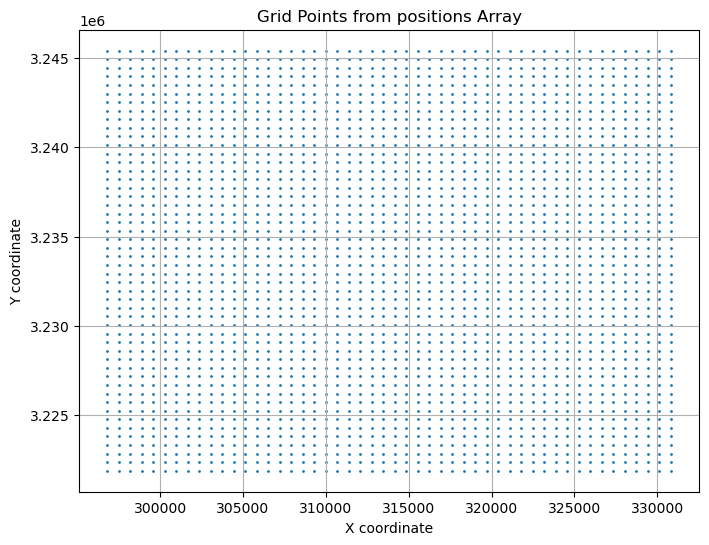

In [42]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(positions[0], positions[1], s=1)  # Plot x and y coordinates of positions
plt.title('Grid Points from positions Array')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.show()

In [43]:
positions

array([[ 296808.1602694 ,  296808.1602694 ,  296808.1602694 , ...,
         330830.56609772,  330830.56609772,  330830.56609772],
       [3221868.73273328, 3222349.3490831 , 3222829.96543292, ...,
        3244457.70117485, 3244938.31752467, 3245418.93387449]])

In [44]:
density

array([[1.86381927e-10, 7.55870529e-11, 1.80856781e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.31333704e-12, 1.82181429e-10, 1.22955742e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.80172456e-17, 1.42792443e-12, 9.32176088e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.70796200e-09, 4.68562018e-09, 1.69235856e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.86345786e-10, 1.10986416e-09, 5.20488223e-10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.45591773e-12, 3.04885583e-10, 1.51997263e-10]])

In [45]:

# Correct any issues with KDE values here, if necessary
# For example, ensure density values are scaled or normalized appropriately

# Define the raster transformation
#transform = from_origin(xmin, ymax, (xmax - xmin) / x_res, (ymax - ymin) / y_res)
# transform = from_origin(west=xmin, north=ymax, xsize=(xmax - xmin) / x_res, ysize=(ymax - ymin) / y_res)
from affine import Affine

# Manually define the affine transformation
# Affine(scale_x, rotation_x, translation_x,
#        rotation_y, scale_y, translation_y)
transform = Affine((xmax - xmin) / x_res, 0, xmin,
                   0, (ymin - ymax) / y_res, ymax)

# Save the raster with the correct CRS
with rasterio.open(
    'kde_rasterv4.tif',
    'w',
    driver='GTiff',
    height=density.shape[0],
    width=density.shape[1],
    count=1,
    dtype=density.dtype,
    crs='EPSG:3857',  # Set the correct CRS here
    transform=transform,
) as dst:
    dst.write(density, 1)

NameError: name 'x_res' is not defined

In [ ]:
from rasterio.plot import show
# Optionally, visualize the original KDE raster
with rasterio.open('kde_rasterv6.tif') as src:
    fig, ax = plt.subplots()
    show(src, ax=ax)
    #other_gdf.plot(ax=ax, color='red', markersize=5)
    plt.show()

In [ ]:
from rasterio.plot import show
import matplotlib.pyplot as plt

# Load the point GeoDataFrame you want to join with KDE values
other_gdf = gpd.read_file('path_to_your_other_point_file.shp').to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# Sample the raster at the points' locations
with rasterio.open('kde_raster.tif') as src:
    # Convert points to the raster coordinate system
    points = [(x, y) for x, y in zip(other_gdf.geometry.x, other_gdf.geometry.y)]
    other_gdf['kde_value'] = [x[0] for x in src.sample(points)]

# Now `other_gdf` contains a new column 'kde_value' with the KDE values at each point's location

# Optionally, visualize the original KDE raster
with rasterio.open('kde_raster.tif') as src:
    fig, ax = plt.subplots()
    show(src, ax=ax)
    other_gdf.plot(ax=ax, color='red', markersize=5)
    plt.show()